# Migrating from MapReduceDocumentsChain

[MapReduceDocumentsChain](https://api.python.langchain.com/en/latest/chains/langchain.chains.combine_documents.map_reduce.MapReduceDocumentsChain.html) implements a map-reduce strategy over (potentially long) texts. The strategy is as follows:

- Split a text into smaller documents;
- Map a process onto the smaller documents;
- Reduce or consolidate the results of the process into a final result.

Note that the map step is typically parallelized over the input documents.

A common process applied in this context is summarization, in which the map step summarizes individual documents, and the reduce step generates a summary of the summaries.

In the reduce step, `MapReduceDocumentsChain` supports a recursive "collapsing" of the summaries: the inputs would be partitioned based on a token limit, and summaries would be generated of the partitions. This step would be repeated until the total length of the summaries was within a desired limit, allowing for the summarization of arbitrary-length text. This is particularly useful for models with smaller context windows.

LangGraph suports [map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) workflows, and confers a number of advantages for this problem:

- LangGraph allows for individual steps (such as successive summarizations) to be streamed, allowing for greater control of execution;
- LangGraph's [checkpointing](https://langchain-ai.github.io/langgraph/how-tos/persistence/) supports error recovery, extending with human-in-the-loop workflows, and easier incorporation into conversational applications.
- The LangGraph implementation is easier to extend, as we will see below.

Below we will go through both `MapReduceDocumentsChain` and a corresponding LangGraph implementation, first on a simple example for illustrative purposes, and second on a longer example text to demonstrate the recursive reduce step.

Let's first load a chat model:

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [1]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

## Basic example (short documents)

Let's use the following 3 documents for illustrative purposes.

In [2]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

### Legacy

<details open>
    
Below we show an implementation with `MapReduceDocumentsChain`. We define the prompt templates for the map and reduce steps, instantiate separate chains for these steps, and finally instantiate the `MapReduceDocumentsChain`:

In [4]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import CharacterTextSplitter

# Map
map_template = "Write a concise summary of the following: {docs}."
map_prompt = ChatPromptTemplate([("human", map_template)])
map_chain = LLMChain(llm=llm, prompt=map_prompt)


# Reduce
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""
reduce_prompt = ChatPromptTemplate([("human", reduce_template)])
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)


# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=1000,
)

# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

In [5]:
result = map_reduce_chain.invoke(documents)

print(result["output_text"])

Fruits come in a variety of colors, with apples being red, blueberries being blue, and bananas being yellow.


In the [LangSmith trace](https://smith.langchain.com/public/8d88a2c0-5d26-41f6-9176-d06549b17aa6/r) we observe four LLM calls: one summarizing each of the three input documents, and one summarizing the summaries.

</details>

### LangGraph

Below we show a LangGraph implementation, using the same prompt templates as above. The graph includes a node for generating summaries which is mapped across a list of input documents. This node then flows to a second node that generates the final summary.

<details open>

We will need to install `langgraph`:

In [ ]:
% pip install -qU langgraph

In [6]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

map_template = "Write a concise summary of the following: {context}."

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

map_prompt = ChatPromptTemplate([("human", map_template)])
reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

map_chain = map_prompt | llm | StrOutputParser()
reduce_chain = reduce_prompt | llm | StrOutputParser()

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["summaries"])
    return {"final_summary": response}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)
graph.add_node("generate_final_summary", generate_final_summary)
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "generate_final_summary")
graph.add_edge("generate_final_summary", END)
app = graph.compile()

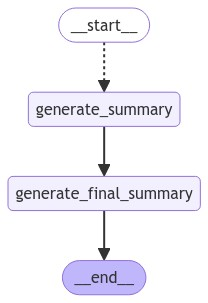

In [7]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

Note that calling the graph in streaming mode allows us to monitor steps and potentially take action on them during execution.

In [8]:
# Call the graph:
async for step in app.astream({"contents": [doc.page_content for doc in documents]}):
    print(step)

{'generate_summary': {'summaries': ['Apples are typically red in color.']}}
{'generate_summary': {'summaries': ['Bananas are yellow in color.']}}
{'generate_summary': {'summaries': ['Blueberries are a type of fruit that are blue in color.']}}
{'generate_final_summary': {'final_summary': 'The main themes are the colors of different fruits: apples are red, blueberries are blue, and bananas are yellow.'}}


In the [LangSmith trace](https://smith.langchain.com/public/8ecbe9fd-eb02-4c6e-90ae-659952c9360a/r) we recover the same four LLM calls as before.

</details>

## Summarizing long documents

Map-reduce flows are particularly useful when texts are long compared to the context window of a LLM. `MapReduceDocumentsChain` supports a recursive "collapsing" of the summaries: the inputs are partitioned based on a token limit, and summaries are generated of the partitions. This step is repeated until the total length of the summaries is within a desired limit, allowing for the summarization of arbitrary-length text.

This "collapse" step is implemented as a `while` loop within `MapReduceDocumentsChain`. We can demonstrate this step on a longer text, a [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng (as featured in the [RAG tutorial](/docs/tutorials/rag) and other documentation).

First we load the post and chunk it into smaller "sub documents":

In [9]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import CharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
documents = loader.load()

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(documents)
print(f"Generated {len(split_docs)} documents.")

USER_AGENT environment variable not set, consider setting it to identify your requests.
Created a chunk of size 1003, which is longer than the specified 1000


Generated 14 documents.


### Legacy

<details open>
We can invoke `MapReduceDocumentsChain` as before:

In [12]:
result = map_reduce_chain.invoke(split_docs)

print(result["output_text"])

The article discusses the use of Large Language Models (LLMs) to power autonomous agents in various tasks, showcasing their capabilities in problem-solving beyond generating written content. Key components such as planning, memory optimization, and tool use are explored, with proof-of-concept demos like AutoGPT and GPT-Engineer demonstrating the potential of LLM-powered agents. Challenges include limitations in historical information retention and natural language interface reliability, while the potential of LLMs in enhancing reasoning, problem-solving, and planning proficiency for autonomous agents is highlighted. Overall, the article emphasizes the versatility and power of LLMs in creating intelligent agents for tasks like scientific discovery and experiment design.


Consider the [LangSmith trace](https://smith.langchain.com/public/d8b3311d-2220-487a-8eaf-104ef90678dd/r) for the above invocation. When instantiating our `ReduceDocumentsChain`, we set a `token_max` of 1,000 tokens. This results in a total of 17 LLM calls:

- 14 calls are for summarizing the 14 sub-documents generated by our text splitter.
- This generated summaries that totaled about 1,000 - 2,000 tokens. Because we set a `token_max` of 1,000, there are two more calls to summarize (or "collapse") these summaries.
- One final call is for generating a final summary of the two "collapsed" summaries.

</details>

### LangGraph

<details open>
We can extend our original map-reduce implementation in LangGraph to implement the same recursive collapsing step. We make the following changes:

- Add a `collapsed_summaries` key to the state to store the collapsed summaries;
- Update the final summarization node to summarize the collapsed summaries;
- Add a `collapse_summaries` node that partitions a list of documents based on a token length (1,000 tokens here, as before) and generates summaries of each partition and stores the result in `collapsed_summaries`.

We add a conditional edge from `collapse_summaries` to itself to form a loop: if the collapsed summaries total more than the `token_max`, we re-run the node.

In [11]:
from typing import Literal

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


token_max = 1000


class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]  # add key for collapsed summaries
    final_summary: str


# Add node to store summaries for collapsing
def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Modify final summary to read off collapsed summaries
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("generate_final_summary", generate_final_summary)


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


graph.add_node("collapse_summaries", collapse_summaries)


def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)
app = graph.compile()

LangGraph allows the graph structure to be plotted to help visualize its function:

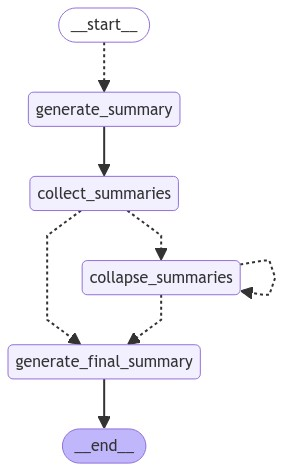

In [12]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

As before, we can stream the graph to observe its sequence of steps. Below, we will simply print out the name of the step.

Note that because we have a loop in the graph, it can be helpful to specify a [recursion_limit](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError) on its execution. This is analogous to [ReduceDocumentsChain.token_max](https://api.python.langchain.com/en/latest/chains/langchain.chains.combine_documents.reduce.ReduceDocumentsChain.html#langchain.chains.combine_documents.reduce.ReduceDocumentsChain.token_max) to will raise a specific error when the specified limit is exceeded.

In [13]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [19]:
print(step)

{'generate_final_summary': {'final_summary': 'The summaries discuss the use of Large Language Models (LLMs) to power autonomous agents in various tasks such as problem-solving, planning, and tool use. Key components like planning, memory, and task decomposition are highlighted, along with challenges such as inefficient planning and hallucination. Techniques like Algorithm Distillation and Maximum Inner Product Search are explored for optimization, while frameworks like ReAct and Reflexion show improvements in knowledge-intensive tasks. The importance of accurate interpretation of user input and well-structured code for functional autonomy is emphasized, along with the potential of LLMs in prompting, reasoning, and emergent social behavior in simulation environments. Challenges in real-world scenarios and the use of LLMs with expert-designed tools for tasks like organic synthesis and drug discovery are also discussed.'}}


In the corresponding [LangSmith trace](https://smith.langchain.com/public/9d7b1d50-e1d6-44c9-9ab2-eabef621c883/r) we can see the same 17 LLM calls as before, this time grouped under their respective nodes.

</details>

## Next steps

Check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) for detail on building with LangGraph, including [this guide](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) on the details of map-reduce in LangGraph.

See [this tutorial](/docs/tutorials/summarization/) for more LLM-based summarization strategies.